# Linear Regression

Let's show how simple it is to evaluate a linear regression with Concrete-ML.

### Let's start by importing some libraries to develop our linear regression model

In [1]:
import time

import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

from concrete.ml.sklearn import LinearRegression as ConcreteLinearRegression

### And some helpers for visualization

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from IPython.display import display

### Let's define our Quantized Linear Regression module that quantizes a sklearn linear regression

In [3]:
# pylint: disable=unbalanced-tuple-unpacking
X, y = make_regression(
    n_samples=200, n_features=1, n_targets=1, bias=5.0, noise=30.0, random_state=42
)
# pylint: enable=unbalanced-tuple-unpacking

# Split it into train/test and sort the sets for nicer visualization
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

sidx = np.argsort(np.squeeze(x_train))
x_train = x_train[sidx, :]
y_train = y_train[sidx]

sidx = np.argsort(np.squeeze(x_test))
x_test = x_test[sidx, :]
y_test = y_test[sidx]

### Train a linear regression on the training set and visualize predictions on the test set

In [4]:
linreg = SklearnLinearRegression()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)

### Visualize the regression line and the data set

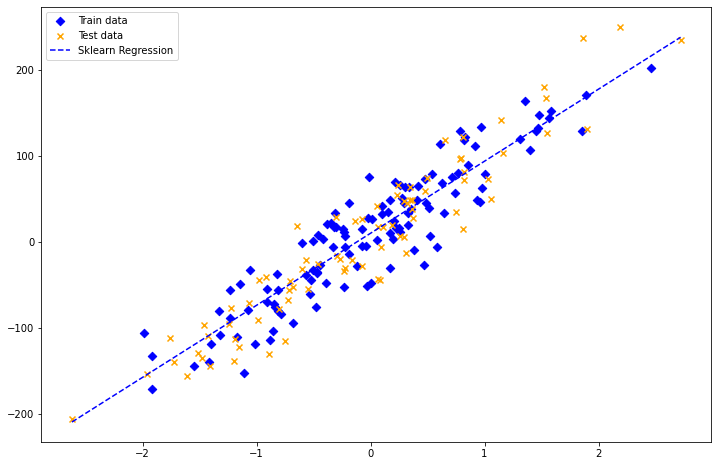

In [5]:
plt.ioff()

plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
ax.scatter(x_train, y_train, c="blue", marker="D", label="Train data")
ax.scatter(x_test, y_test, c="orange", marker="x", label="Test data")
ax.plot(x_test, y_pred, c="blue", marker=None, linestyle="dashed", label="Sklearn Regression")
ax.legend()
display(fig)

### Calibrate the model for quantization using both training and test data


In [ ]:
q_linreg = ConcreteLinearRegression(
    n_bits={"net_inputs": 6, "op_inputs": 6, "op_weights": 1, "net_outputs": 6}
)
q_linreg.fit(x_train, y_train)

LinearRegression(n_bits={'net_inputs': 6, 'net_outputs': 6, 'op_inputs': 6,
                         'op_weights': 1})

### Time to make some predictions, first in the clear

In [7]:
# Now that the model is quantized, predict on the test set
y_pred_q = q_linreg.predict(x_test)

### Now, we can compile our model to FHE, taking as the possible input set all of our dataset

In [8]:
circuit = q_linreg.compile(X)

### Generate the key

In [9]:
print(f"Generating a key for an {circuit.graph.maximum_integer_bit_width()}-bit circuit")

Generating a key for an 7-bit circuit


In [10]:
time_begin = time.time()
circuit.client.keygen(force=False)
print(f"Key generation time: {time.time() - time_begin:.2f} seconds")

Key generation time: 818.53 seconds


### Now let's predict using the quantized FHE classifier

In [11]:
# Now predict using the FHE-quantized model on the testing set
time_begin = time.time()
y_test_pred_fhe = q_linreg.predict(x_test, execute_in_fhe=True)
print(f"Execution time: {(time.time() - time_begin) / len(x_test):.2f} seconds per sample")

Execution time: 1.96 seconds per sample


### Evaluate all versions of the classifier

In [12]:
# Measure the error for the three versions of the classifier
sklearn_r2 = r2_score(y_pred, y_test)
non_homomorphic_test_error = r2_score(y_pred_q, y_test)
homomorphic_test_error = r2_score(y_test_pred_fhe, y_test)

# Measure the error of the FHE quantized model w.r.t the clear quantized model
difference = (
    abs(homomorphic_test_error - non_homomorphic_test_error) * 100 / non_homomorphic_test_error
)


print(f"Sklearn R^2: {sklearn_r2:.4f}")
print(f"Non Homomorphic R^2: {non_homomorphic_test_error:.4f}")
print(f"Homomorphic R^2: {homomorphic_test_error:.4f}")
print(f"Relative Difference Percentage: {difference:.2f}%")

Sklearn R^2: 0.8758
Non Homomorphic R^2: 0.8627
Homomorphic R^2: 0.8627
Relative Difference Percentage: 0.00%


### Plot the results of both the original and FHE versions of the classifier

In [13]:
# Create a new x that covers the entire space of the original x
x_space = np.linspace(x_test.min(), x_test.max(), 100)
x_space = x_space[:, np.newaxis]
y_pred_space_q = q_linreg.predict(x_space)

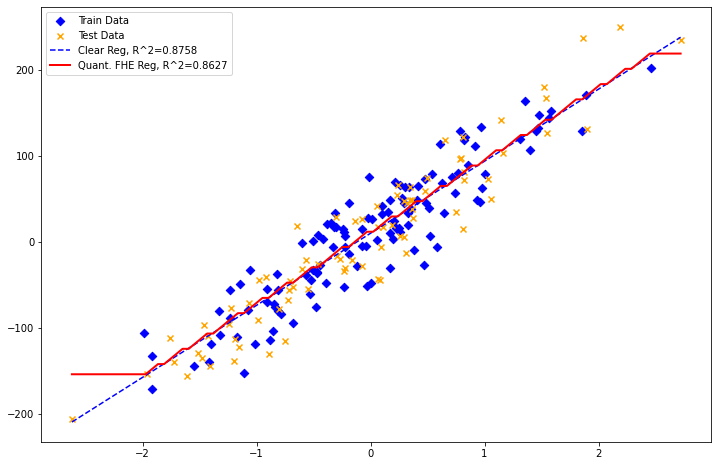

In [14]:
plt.clf()
fig, ax = plt.subplots(1, figsize=(12, 8))
fig.patch.set_facecolor("white")
s1 = ax.scatter(x_train, y_train, c="blue", marker="D")
s2 = ax.scatter(x_test, y_test, c="orange", marker="x")
p1 = ax.plot(x_test, y_pred, c="blue", marker=None, linestyle="dashed")
p2 = ax.plot(x_space, y_pred_space_q, c="red", marker=None, linewidth=2)
ax.legend(
    [s1, s2, p1[0], p2[0]],
    [
        "Train Data",
        "Test Data",
        f"Clear Reg, R^2={sklearn_r2:.4f}",
        f"Quant. FHE Reg, R^2={homomorphic_test_error:.4f}",
    ],
)
display(fig)